<a href="https://colab.research.google.com/gist/Nemezjusz/98cf8c50bf7ba6efb6ce0adb06f66a5c/model_trainer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

data = pd.read_csv('DataEURUSD.csv')

data

,Date,Open,High,Low,Close,Adj Close,Volume,Prediction_NextInterval,Target
0,2003-12-01,1.203398,1.204007,1.194401,1.196501,1.196501,0,1.208897,1
1,2003-12-02,1.196101,1.210903,1.194600,1.208897,1.208897,0,1.212298,1
2,2003-12-03,1.209000,1.213003,1.207700,1.212298,1.212298,0,1.208094,0
3,2003-12-04,1.212004,1.214403,1.204398,1.208094,1.208094,0,1.218695,1
4,2003-12-05,1.207802,1.219096,1.206593,1.218695,1.218695,0,1.222001,1
...,...,...,...,...,...,...,...,...,...
5213,2024-01-03,1.094176,1.096700,1.089871,1.094176,1.094176,0,1.092777,0
5214,2024-01-04,1.092777,1.097021,1.091703,1.092777,1.092777,0,1.094739,1
5215,2024-01-05,1.094739,1.099638,1.087985,1.094739,1.094739,0,1.094224,0
5216,2024-01-08,1.094224,1.097815,1.092454,1.094224,1.094224,0,1.093016,0


In [2]:
data = data[['Date', 'Close']]
data

,Date,Close
0,2003-12-01,1.196501
1,2003-12-02,1.208897
2,2003-12-03,1.212298
3,2003-12-04,1.208094
4,2003-12-05,1.218695
...,...,...
5213,2024-01-03,1.094176
5214,2024-01-04,1.092777
5215,2024-01-05,1.094739
5216,2024-01-08,1.094224


In [3]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device

'cuda:0'

<ipython-input-4-27440ea654b2>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = pd.to_datetime(data['Date'])


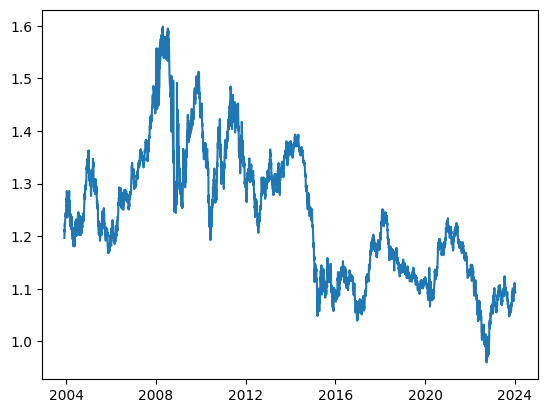

In [4]:
data['Date'] = pd.to_datetime(data['Date'])

plt.plot(data['Date'], data['Close'])

In [5]:
from copy import deepcopy as dc

def prepare_dataframe_for_lstm(df, n_steps):
    df = dc(df)

    df.set_index('Date', inplace=True)

    for i in range(1, n_steps+1):
        df[f'Close(t-{i})'] = df['Close'].shift(i)

    df.dropna(inplace=True)

    return df

lookback = 7
shifted_df = prepare_dataframe_for_lstm(data, lookback)
shifted_df

,Close,Close(t-1),Close(t-2),Close(t-3),Close(t-4),Close(t-5),Close(t-6),Close(t-7)
Date,,,,,,,,
2003-12-10,1.219096,1.224995,1.222001,1.218695,1.208094,1.212298,1.208897,1.196501
2003-12-11,1.222404,1.219096,1.224995,1.222001,1.218695,1.208094,1.212298,1.208897
2003-12-12,1.227898,1.222404,1.219096,1.224995,1.222001,1.218695,1.208094,1.212298
2003-12-15,1.231997,1.227898,1.222404,1.219096,1.224995,1.222001,1.218695,1.208094
2003-12-16,1.232195,1.231997,1.227898,1.222404,1.219096,1.224995,1.222001,1.218695
...,...,...,...,...,...,...,...,...
2024-01-03,1.094176,1.103875,1.105583,1.106819,1.110864,1.104301,1.102026,1.102657
2024-01-04,1.092777,1.094176,1.103875,1.105583,1.106819,1.110864,1.104301,1.102026
2024-01-05,1.094739,1.092777,1.094176,1.103875,1.105583,1.106819,1.110864,1.104301


In [6]:
shifted_df_as_np = shifted_df.to_numpy()

shifted_df_as_np

array([[1.21909595, 1.22499478, 1.22200096, ..., 1.21229756, 1.20889747,
        1.19650137],
       [1.22240424, 1.21909595, 1.22499478, ..., 1.20809424, 1.21229756,
        1.20889747],
       [1.22789776, 1.22240424, 1.21909595, ..., 1.21869469, 1.20809424,
        1.21229756],
       ...,
       [1.09473872, 1.09277678, 1.0941757 , ..., 1.10681915, 1.11086428,
        1.10430121],
       [1.09422362, 1.09473872, 1.09277678, ..., 1.10558319, 1.10681915,
        1.11086428],
       [1.09301567, 1.09422362, 1.09473872, ..., 1.10387456, 1.10558319,
        1.10681915]])

In [7]:
shifted_df_as_np.shape

(5211, 8)

In [8]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1))
shifted_df_as_np = scaler.fit_transform(shifted_df_as_np)

shifted_df_as_np

array([[-0.18809307, -0.16963553, -0.17900324, ..., -0.20936533,
        -0.22000426, -0.25879184],
       [-0.17774136, -0.18809307, -0.16963553, ..., -0.22251758,
        -0.20936533, -0.22000426],
       [-0.16055204, -0.17774136, -0.18809307, ..., -0.18934861,
        -0.22251758, -0.20936533],
       ...,
       [-0.57720878, -0.58334774, -0.57897049, ..., -0.53940892,
        -0.52675165, -0.54728759],
       [-0.57882055, -0.57720878, -0.58334774, ..., -0.54327627,
        -0.53940892, -0.52675165],
       [-0.58260023, -0.57882055, -0.57720878, ..., -0.54862258,
        -0.54327627, -0.53940892]])

In [9]:
X = shifted_df_as_np[:, 1:]
y = shifted_df_as_np[:, 0]

X.shape, y.shape

((5211, 7), (5211,))

In [10]:
X = dc(np.flip(X, axis=1))
X

array([[-0.25879184, -0.22000426, -0.20936533, ..., -0.18934861,
        -0.17900324, -0.16963553],
       [-0.22000426, -0.20936533, -0.22251758, ..., -0.17900324,
        -0.16963553, -0.18809307],
       [-0.20936533, -0.22251758, -0.18934861, ..., -0.16963553,
        -0.18809307, -0.17774136],
       ...,
       [-0.54728759, -0.52675165, -0.53940892, ..., -0.54862258,
        -0.57897049, -0.58334774],
       [-0.52675165, -0.53940892, -0.54327627, ..., -0.57897049,
        -0.58334774, -0.57720878],
       [-0.53940892, -0.54327627, -0.54862258, ..., -0.58334774,
        -0.57720878, -0.57882055]])

In [11]:
split_index = int(len(X) * 0.95)

split_index

4950

In [12]:
X_train = X[:split_index]
X_test = X[split_index:]

y_train = y[:split_index]
y_test = y[split_index:]

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((4950, 7), (261, 7), (4950,), (261,))

In [13]:
X_train = X_train.reshape((-1, lookback, 1))
X_test = X_test.reshape((-1, lookback, 1))

y_train = y_train.reshape((-1, 1))
y_test = y_test.reshape((-1, 1))

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((4950, 7, 1), (261, 7, 1), (4950, 1), (261, 1))

In [14]:
X_train = torch.tensor(X_train).float()
y_train = torch.tensor(y_train).float()
X_test = torch.tensor(X_test).float()
y_test = torch.tensor(y_test).float()

X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([4950, 7, 1]),
 torch.Size([261, 7, 1]),
 torch.Size([4950, 1]),
 torch.Size([261, 1]))

In [15]:
from torch.utils.data import Dataset

class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, i):
        return self.X[i], self.y[i]

train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_test, y_test)

In [16]:
train_dataset

In [17]:
from torch.utils.data import DataLoader

batch_size = 16

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [18]:
for _, batch in enumerate(train_loader):
    x_batch, y_batch = batch[0].to(device), batch[1].to(device)
    print(x_batch.shape, y_batch.shape)
    break

torch.Size([16, 7, 1]) torch.Size([16, 1])


In [19]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_stacked_layers):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_stacked_layers = num_stacked_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_stacked_layers,
                            batch_first=True)

        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        c0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)

        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

model = LSTM(1, 4, 1)
model.to(device)
model

LSTM(
  (lstm): LSTM(1, 4, batch_first=True)
  (fc): Linear(in_features=4, out_features=1, bias=True)
)

In [20]:
def train_one_epoch():
    model.train(True)
    print(f'Epoch: {epoch + 1}')
    running_loss = 0.0

    for batch_index, batch in enumerate(train_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)

        output = model(x_batch)
        loss = loss_function(output, y_batch)
        running_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_index % 100 == 99:  # print every 100 batches
            avg_loss_across_batches = running_loss / 100
            print('Batch {0}, Loss: {1:.3f}'.format(batch_index+1,
                                                    avg_loss_across_batches))
            running_loss = 0.0
    print()

In [21]:
def validate_one_epoch():
    model.train(False)
    running_loss = 0.0

    for batch_index, batch in enumerate(test_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)

        with torch.no_grad():
            output = model(x_batch)
            loss = loss_function(output, y_batch)
            running_loss += loss.item()

    avg_loss_across_batches = running_loss / len(test_loader)

    print('Val Loss: {0:.3f}'.format(avg_loss_across_batches))
    print('***************************************************')
    print()

In [ ]:
learning_rate = 0.001
num_epochs = 10
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    train_one_epoch()
    validate_one_epoch()

In [30]:
from pathlib import Path

# 1. Create models directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create model save path
MODEL_NAME = "Model_EURUSD.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save the model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model.state_dict(), # only saving the state_dict() only saves the models learned parameters
           f=MODEL_SAVE_PATH)


Saving model to: models/Model_EURUSD.pth


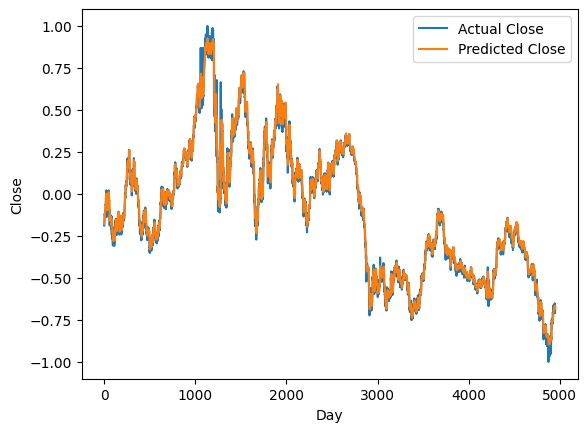

In [23]:
with torch.no_grad():
    predicted = model(X_train.to(device)).to('cpu').numpy()

plt.plot(y_train, label='Actual Close')
plt.plot(predicted, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()


In [24]:
train_predictions = predicted.flatten()

dummies = np.zeros((X_train.shape[0], lookback+1))
dummies[:, 0] = train_predictions
dummies = scaler.inverse_transform(dummies)

train_predictions = dc(dummies[:, 0])
train_predictions

array([1.22249768, 1.22227803, 1.22381465, ..., 1.0636869 , 1.06300979,
       1.06040644])

In [25]:
dummies = np.zeros((X_train.shape[0], lookback+1))
dummies[:, 0] = y_train.flatten()
dummies = scaler.inverse_transform(dummies)

new_y_train = dc(dummies[:, 0])
new_y_train

array([1.21909595, 1.22240424, 1.22789776, ..., 1.06063653, 1.05222178,
       1.06563234])

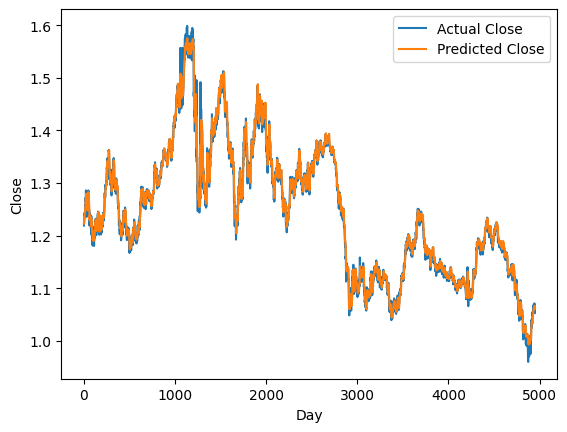

In [26]:
plt.plot(new_y_train, label='Actual Close')
plt.plot(train_predictions, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()


In [ ]:
test_predictions = model(X_test.to(device)).detach().cpu().numpy().flatten()

dummies = np.zeros((X_test.shape[0], lookback+1))
dummies[:, 0] = test_predictions
dummies = scaler.inverse_transform(dummies)

test_predictions = dc(dummies[:, 0])
test_predictions

In [ ]:
dummies = np.zeros((X_test.shape[0], lookback+1))
dummies[:, 0] = y_test.flatten()
dummies = scaler.inverse_transform(dummies)

new_y_test = dc(dummies[:, 0])
new_y_test

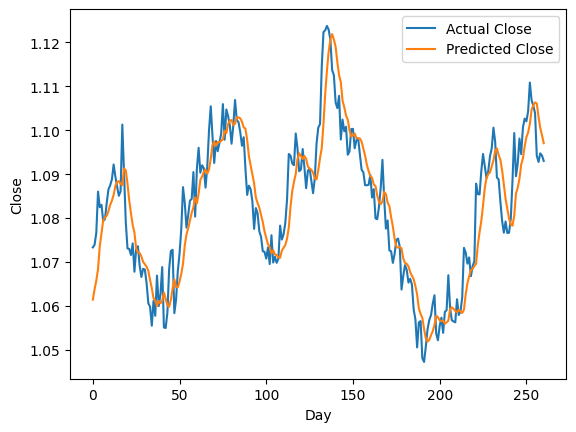

In [29]:
plt.plot(new_y_test, label='Actual Close')
plt.plot(test_predictions, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()
